In [1]:
# Libraries

import json
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tqdm import tqdm # It shows nice progress bars

# Input data files are available in the read-only "../input/" directory
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 1. Load and show training data

## Set base directories

In [2]:
asl_signs_dir = '../input/asl-signs/'

## Show contents of train.csv

In [3]:
train_file = 'train.csv'
train_df = pd.read_csv(os.path.join(asl_signs_dir, train_file), encoding='utf8')

print(f'Samples, columns: {train_df.shape}')
print(train_df.dtypes)
train_df.head()

Samples, columns: (94477, 4)
path              object
participant_id     int64
sequence_id        int64
sign              object
dtype: object


,path,participant_id,sequence_id,sign
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie


## Show the contents of a random file in path column of train.csv

In [16]:
random_sample = train_df.sample()
random_sample_path = random_sample['path'].values[0]


print('the path is',random_sample_path)

parquet_df = pd.read_parquet(os.path.join(asl_signs_dir, random_sample_path))
print(parquet_df.dtypes)
parquet_df.head()


the path is train_landmark_files/25571/4082575456.parquet
frame               int16
row_id             object
type               object
landmark_index      int16
x                 float64
y                 float64
z                 float64
dtype: object


,frame,row_id,type,landmark_index,x,y,z
0,76,76-face-0,face,0,0.538889,0.440412,-0.036194
1,76,76-face-1,face,1,0.536886,0.412971,-0.071491
2,76,76-face-2,face,2,0.541170,0.422060,-0.038326
3,76,76-face-3,face,3,0.525240,0.378960,-0.052912
4,76,76-face-4,face,4,0.535571,0.402391,-0.075880


In [33]:
parquet_df[parquet_df['landmark_index'] == 20]

,frame,row_id,type,landmark_index,x,y,z
20,76,76-face-20,face,20,0.527148,0.418300,-0.046021
488,76,76-left_hand-20,left_hand,20,NaN,NaN,NaN
509,76,76-pose-20,pose,20,0.499477,0.539366,-3.119217
542,76,76-right_hand-20,right_hand,20,0.518658,0.452202,-0.059749
563,77,77-face-20,face,20,0.524626,0.417534,-0.046812
...,...,...,...,...,...,...,...
22805,117,117-right_hand-20,right_hand,20,0.114837,0.697266,-0.337827
22826,118,118-face-20,face,20,0.516563,0.410571,-0.042970
23294,118,118-left_hand-20,left_hand,20,NaN,NaN,NaN
23315,118,118-pose-20,pose,20,0.344196,0.696900,-3.279048


So, for a given sign done by a participant (in a given sequence), we have a set of landmarks that describe the sign in a parquet file. It would be nice to see the landmarks for a random sign.

## Check if the data is clean

In [34]:
print(f"# null values: {parquet_df.isnull().sum().sum()}")
print(f"# rows: {len(parquet_df)}, # rows without duplicates: "
      f"{len(parquet_df.drop_duplicates())}")
parquet_df.describe()

# null values: 3780
# rows: 23349, # rows without duplicates: 23349


,frame,landmark_index,x,y,z
count,23349.000000,23349.000000,22089.000000,22089.000000,22089.000000
mean,97.000000,202.994475,0.537272,0.434265,-0.079277
std,12.409939,146.793362,0.093347,0.206985,0.407604
min,76.000000,0.000000,-0.001065,0.257906,-3.541146
25%,86.000000,60.000000,0.488636,0.350765,-0.028355
50%,97.000000,196.000000,0.532745,0.405007,-0.006174
75%,108.000000,332.000000,0.590073,0.446459,0.011918
max,118.000000,467.000000,1.084517,2.062235,2.017421


In [45]:
(parquet_df['x'] > 1).value_counts()

False    23313
True        36
Name: x, dtype: int64

So, there are null values, no duplicates, and the normalized coordinates are not in the range [0, 1]. We can just remove all weird values.

In [46]:
# Remove null
parquet_df_clean = parquet_df.dropna()

# Remove rows where x or y are not in [0, 1]. Ignore z for now
parquet_df_clean = parquet_df_clean[(parquet_df_clean.x >= 0) & 
                                    (parquet_df_clean.x <= 1) &
                                    (parquet_df_clean.y >= 0) & 
                                    (parquet_df_clean.y <= 1)]

# Note, we could remove the entire landmark of a frame if one of its
# coordinates is bad (a whole face or hand), and not just one point,
# but I am lazy at the moment

In [47]:
# Check cleanliness again
print(f"# null values: {parquet_df_clean.isnull().sum().sum()}")
print(f"# rows: {len(parquet_df_clean)}, # rows without duplicates: "
      f"{len(parquet_df_clean.drop_duplicates())}")
parquet_df_clean.describe()

# null values: 0
# rows: 21492, # rows without duplicates: 21492


,frame,landmark_index,x,y,z
count,21492.000000,21492.000000,21492.000000,21492.000000,21492.000000
mean,96.903080,219.259585,0.536508,0.403749,-0.072136
std,12.435296,141.692368,0.081541,0.075387,0.382198
min,76.000000,0.000000,0.008973,0.257906,-3.541146
25%,86.000000,93.000000,0.489229,0.350039,-0.027228
50%,97.000000,218.000000,0.531456,0.402568,-0.005995
75%,108.000000,343.000000,0.588959,0.444480,0.011518
max,118.000000,467.000000,0.968063,0.999966,0.159222


In [51]:
(parquet_df_clean['frame'] == 76).value_counts()

False    20984
True       508
Name: frame, dtype: int64

## Display landmarks for a random sign (listed in a parquet file), just in 2D for now as depth can be tricky

Let's see which landmark types and frame indexes are in the randon parquet we chose and cleaned

In [48]:
# Print landmark types per frame in a parquet
for frame_id in parquet_df_clean.frame.unique().tolist():
    list_types = []
    print(f"Frame: {frame_id}")
    
    for landmark_type in parquet_df_clean[
        parquet_df_clean.frame == frame_id].type.unique().tolist():
        list_types.append(landmark_type)
        
    print(list_types)

Frame: 76
['face', 'pose', 'right_hand']
Frame: 77
['face', 'pose', 'right_hand']
Frame: 78
['face', 'pose']
Frame: 79
['face', 'pose', 'right_hand']
Frame: 80
['face', 'pose', 'right_hand']
Frame: 81
['face', 'pose', 'right_hand']
Frame: 82
['face', 'pose', 'right_hand']
Frame: 83
['face', 'pose', 'right_hand']
Frame: 84
['face', 'pose', 'right_hand']
Frame: 85
['face', 'pose', 'right_hand']
Frame: 86
['face', 'pose', 'right_hand']
Frame: 87
['face', 'pose', 'right_hand']
Frame: 88
['face', 'pose', 'right_hand']
Frame: 89
['face', 'pose', 'right_hand']
Frame: 90
['face', 'pose']
Frame: 91
['face', 'pose']
Frame: 92
['face', 'pose', 'right_hand']
Frame: 93
['face', 'pose', 'right_hand']
Frame: 94
['face', 'pose', 'right_hand']
Frame: 95
['face', 'pose', 'right_hand']
Frame: 96
['face', 'pose', 'right_hand']
Frame: 97
['face', 'pose', 'right_hand']
Frame: 98
['face', 'pose', 'right_hand']
Frame: 99
['face', 'pose', 'right_hand']
Frame: 100
['face', 'pose']
Frame: 101
['face', 'pose']
Fr

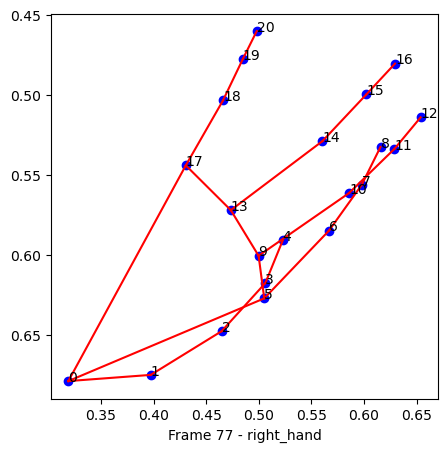

In [55]:
# Define some global values for the plots
edges = [(0,1),(1,2),(2,3),(3,4),(0,5),(0,17),(5,6),
         (6,7),(7,8),(5,9),(9,10),(10,11),(11,12),
         (9,13),(13,14),(14,15),(15,16),(13,17),
         (17,18),(18,19),(19,20)]

colors = ['blue', 'green', 'orange', 'brown', 'purple']

# Plot one specific type of landmark
def plot_frame_landmark(parquet_df, frame_id, landmark_type, axes):
    parquet_df_sorted_filtered = parquet_df[
            (parquet_df.frame == frame_id) &
            (parquet_df.type == landmark_type)
        ].sort_values(['landmark_index'])
    
    x = list(parquet_df_sorted_filtered.x)
    y = list(parquet_df_sorted_filtered.y)

    axes.scatter(x, y, color='blue')
    
    for i in range(len(x)):
        axes.text(x[i], y[i], str(i))
        
    axes.set_xlabel(f"Frame {frame_id} - {landmark_type}")
    
    # Draw edges if it is a hand, for better visualization
    # Nice code from:
    # https://www.kaggle.com/code/mayukh18/sign-language-eda-visualization/notebook
    
    if 'hand' in landmark_type:
        for edge in edges:
            axes.plot([x[edge[0]], x[edge[1]]], 
                      [y[edge[0]], y[edge[1]]], 
                      color='red')
            
# Choose a frame and landmark type to plot
frame_id_show = 77
landmark_type_show = 'right_hand'

# Make sure the frame - landmark type combo exists
if frame_id_show in parquet_df_clean.frame.unique().tolist():
    if landmark_type_show in parquet_df_clean[
        parquet_df_clean.frame == frame_id_show].type.unique().tolist():
            _, axes = plt.subplots(1, 1, figsize=(5, 5))
            plot_frame_landmark(parquet_df_clean, frame_id_show, landmark_type_show, axes)      
            plt.gca().invert_yaxis() # Invert the y axis to see better
            plt.show()
    else:
        print("The landmark you chose does not exist in the frame of the parquet.")
else:
    print("The frame you chose does not exist in the parquet.")

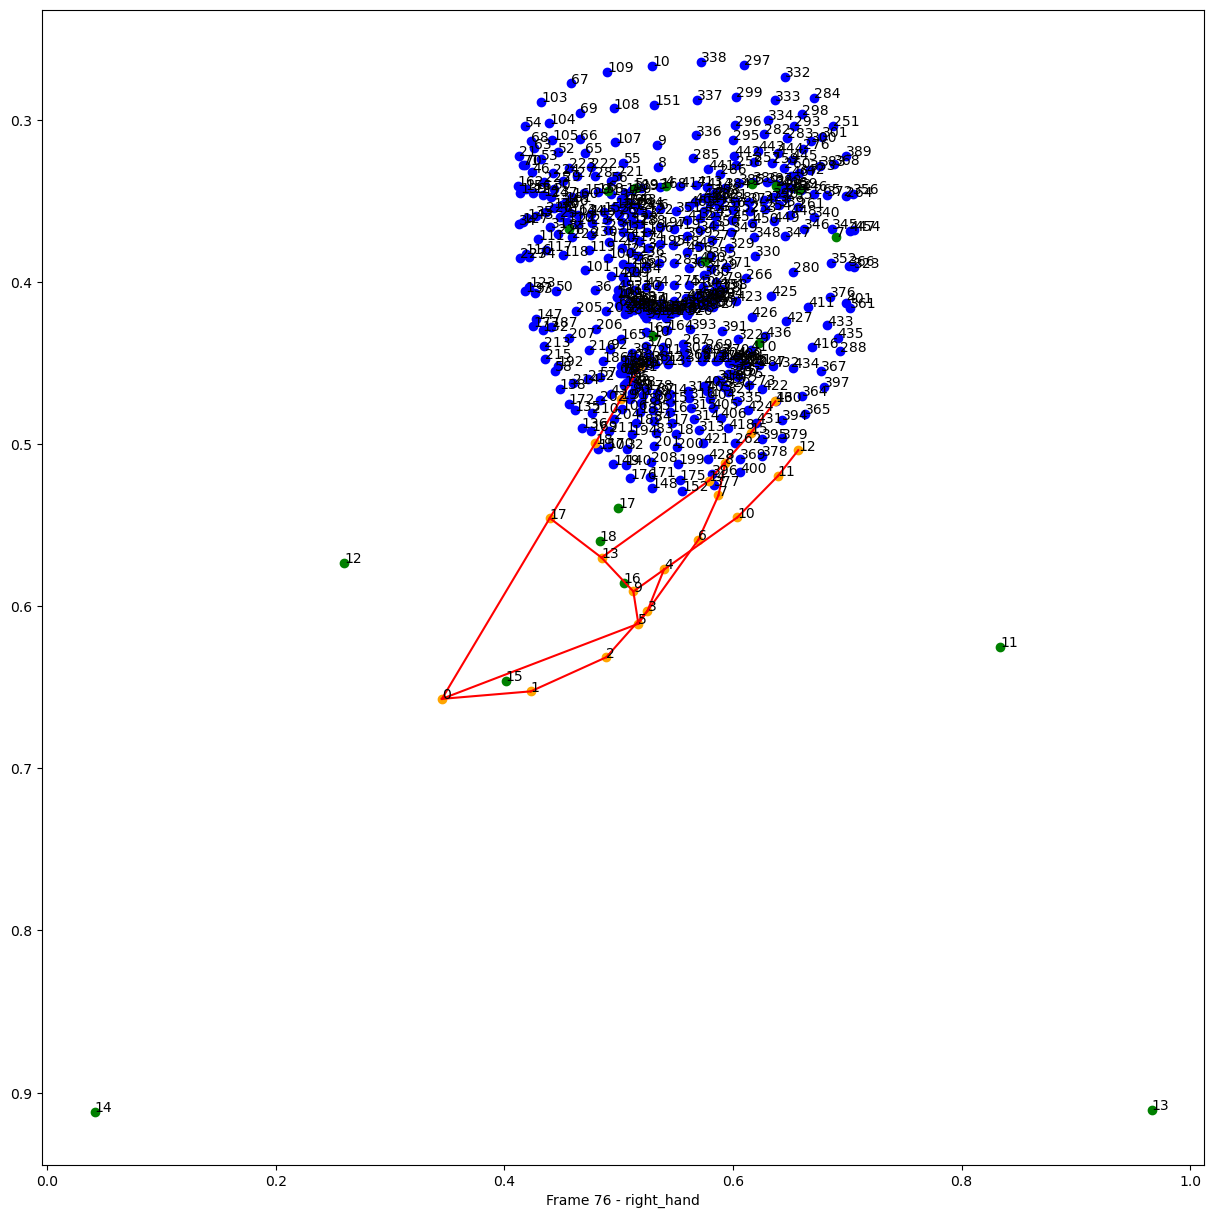

In [57]:
# Plot the whole frame with all landmarks
def plot_frame(parquet_df, frame_id, axes):
    
    color_id = 0
    
    for landmark_type in parquet_df[
        parquet_df.frame == frame_id].type.unique().tolist():
        
        parquet_df_sorted_filtered = parquet_df[
                (parquet_df.frame == frame_id) &
                (parquet_df.type == landmark_type)
            ].sort_values(['landmark_index'])

        x = list(parquet_df_sorted_filtered.x)
        y = list(parquet_df_sorted_filtered.y)

        axes.scatter(x, y, color=colors[color_id])
        color_id += 1

        for i in range(len(x)):
            axes.text(x[i], y[i], str(i))

        # Add edges for a hand
        if 'hand' in landmark_type:
            for edge in edges:
                axes.plot([x[edge[0]], x[edge[1]]], 
                          [y[edge[0]], y[edge[1]]], 
                          color='red')
        
    axes.set_xlabel(f"Frame {frame_id} - {landmark_type}")
    
# Choose a frame to plot
frame_id_show = 76

# Make sure the frame exists, to avoid errors
if frame_id_show in parquet_df_clean.frame.unique().tolist():
    _, axes = plt.subplots(1, 1, figsize=(15, 15))
    plot_frame(parquet_df_clean, frame_id_show, axes)      
    plt.gca().invert_yaxis() # Invert the y axis to see better
    plt.show()
else:
    print("The frame you chose does not exist in the parquet.")

Now, we can plot a sequence of frames that mean a sign

In [58]:
def plot_frames_parquet(parquet_df):
    frames_in_parquet = np.sort(parquet_df.frame.unique()).tolist()
    n_frames = len(frames_in_parquet)
    n_cols = 3
    n_rows = math.floor(n_frames / n_cols) + 1   
    
    _, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))
      
    for i in range(n_frames):
        n_row = math.floor(i / n_cols)
        n_col = i % n_cols
        plot_frame(parquet_df, frames_in_parquet[i], axes[n_row][n_col])
        axes[n_row][n_col].invert_yaxis() # It looks better inverted
        
print(random_sample.sign.values[0]) # Sign value
# plot_frames_parquet(parquet_df_clean)
plt.show()

hot


# 2. Prepare a dataset to train a neural network

In [59]:
# Check that sequence id identifies each row in train dataset with no duplicates

print(f"# unique sequence ids: {len(np.unique(train_df.sequence_id.values))}\n"
      f"# rows train: {len(train_df)}")

# unique sequence ids: 94477
# rows train: 94477


The instructions indicate that the model must take one or more landmark frames as an input and return a float vector (the predicted probabilities of each sign class) as the output and data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns)).

So, the input has to contain an array of landmark coordinates in a frame, with ROWS_PER_FRAME rows per frame (each row is a landmark coord), and 3 columns: x, y, and z. That's what I understood up to now. 

In [60]:
# Function to load data taken directly from:
# https://www.kaggle.com/competitions/asl-signs/overview/evaluation

ROWS_PER_FRAME = 543  # number of landmarks per frame

def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return data.astype(np.float32)

In [61]:
# Get the mapping of signs to codes
dict_signs_name = "sign_to_prediction_index_map.json"
dict_signs_path = os.path.join(asl_signs_dir, dict_signs_name)
dict_sign_to_code = None
with open(dict_signs_path, "r") as f:
    dict_sign_to_code = json.load(f)

print(dict_sign_to_code)

{'TV': 0, 'after': 1, 'airplane': 2, 'all': 3, 'alligator': 4, 'animal': 5, 'another': 6, 'any': 7, 'apple': 8, 'arm': 9, 'aunt': 10, 'awake': 11, 'backyard': 12, 'bad': 13, 'balloon': 14, 'bath': 15, 'because': 16, 'bed': 17, 'bedroom': 18, 'bee': 19, 'before': 20, 'beside': 21, 'better': 22, 'bird': 23, 'black': 24, 'blow': 25, 'blue': 26, 'boat': 27, 'book': 28, 'boy': 29, 'brother': 30, 'brown': 31, 'bug': 32, 'bye': 33, 'callonphone': 34, 'can': 35, 'car': 36, 'carrot': 37, 'cat': 38, 'cereal': 39, 'chair': 40, 'cheek': 41, 'child': 42, 'chin': 43, 'chocolate': 44, 'clean': 45, 'close': 46, 'closet': 47, 'cloud': 48, 'clown': 49, 'cow': 50, 'cowboy': 51, 'cry': 52, 'cut': 53, 'cute': 54, 'dad': 55, 'dance': 56, 'dirty': 57, 'dog': 58, 'doll': 59, 'donkey': 60, 'down': 61, 'drawer': 62, 'drink': 63, 'drop': 64, 'dry': 65, 'dryer': 66, 'duck': 67, 'ear': 68, 'elephant': 69, 'empty': 70, 'every': 71, 'eye': 72, 'face': 73, 'fall': 74, 'farm': 75, 'fast': 76, 'feet': 77, 'find': 78, '

In [62]:
xs = None
ys = []

# Use only the first 250, because there are just too many rows
for row in tqdm(train_df.head(250).itertuples()):
    full_path = os.path.join(asl_signs_dir, row.path)    
    
    # We need to clean and do some preprocessing, but as the model
    # has to do all that with the test data too, I will include
    # the preprocessing in the tensorflow model    
    loaded_data = load_relevant_data_subset(full_path)
    
    xs = loaded_data if xs is None else np.concatenate((xs, loaded_data), axis=0)
    
    for i in range(len(loaded_data)):
        ys.append(dict_sign_to_code[row.sign])
    
print(xs.shape)
ys = np.array(ys)
print(ys.shape)
print(xs[0])
print(ys)

250it [00:06, 35.87it/s]

(8741, 543, 3)
(8741,)
[[ 0.49440014  0.38046983 -0.03062646]
 [ 0.49601725  0.3507348  -0.05756483]
 [ 0.5008185   0.35934305 -0.03028346]
 ...
 [ 0.31373617  0.41234398 -0.05269891]
 [ 0.35072815  0.39958185 -0.06021732]
 [ 0.38579622  0.4011007  -0.06471767]]
[25 25 25 ... 27 27 27]


In [64]:
len(ys)

8741

In [65]:
# Try with a random model I got from:
# https://www.kaggle.com/code/lonnieqin/isolated-sign-language-recognition-with-dnn
def get_model():
    inputs = tf.keras.Input((543, 3), dtype=tf.float32, name="inputs")
    vector = tf.where(tf.math.is_nan(inputs), tf.zeros_like(inputs), inputs)
    vector = tf.keras.layers.Dense(128, activation="relu")(vector)
    vector = tf.keras.layers.Dense(64, activation="relu")(vector)
    vector = tf.keras.layers.Dense(32, activation="relu")(vector)
    vector = tf.keras.layers.Dense(16, activation="relu")(vector)
    vector = tf.keras.layers.Flatten()(vector)
    vector = tf.keras.layers.Dense(250, activation="softmax")(vector)
    output = tf.keras.layers.Activation(activation="linear", name="outputs")(vector)
    model = tf.keras.Model(inputs=inputs, outputs=output)
    learning_rate = 1e-3
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
        metrics=[
            "accuracy", 
            tf.keras.metrics.SparseTopKCategoricalAccuracy(k=10)
        ],
        optimizer=optimizer
    )
    return model

In [66]:
X_train, X_val, y_train, y_val = train_test_split(xs, ys, test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

# del xs, ys
# gc.collect()

model = get_model()
callbacks = [tf.keras.callbacks.ModelCheckpoint("model.h5")]
model.fit(X_train, y_train, epochs=3, validation_data=(X_val, y_val), batch_size=128, callbacks=callbacks)
model.summary()

(6992, 543, 3) (6992,) (1749, 543, 3) (1749,)
Epoch 1/3
55/55 [==============================] - 12s 188ms/step - loss: 4.2050 - accuracy: 0.1221 - sparse_top_k_categorical_accuracy: 0.4126 - val_loss: 3.2024 - val_accuracy: 0.3019 - val_sparse_top_k_categorical_accuracy: 0.6627
Epoch 2/3
55/55 [==============================] - 9s 167ms/step - loss: 2.3882 - accuracy: 0.4703 - sparse_top_k_categorical_accuracy: 0.7946 - val_loss: 1.9139 - val_accuracy: 0.5643 - val_sparse_top_k_categorical_accuracy: 0.8599
Epoch 3/3
55/55 [==============================] - 9s 160ms/step - loss: 1.4004 - accuracy: 0.6660 - sparse_top_k_categorical_accuracy: 0.9191 - val_loss: 1.2685 - val_accuracy: 0.7210 - val_sparse_top_k_categorical_accuracy: 0.9211
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 5

In [67]:
prediction = model.predict(xs[0:5])
print(np.argmax(prediction[0]))
print(prediction[0])

1/1 [==============================] - 0s 207ms/step
236
[1.36088056e-08 1.54230808e-13 2.37644458e-13 9.83924201e-06
 1.38843795e-02 2.75713239e-14 7.34561500e-13 4.08783353e-06
 2.34579613e-15 1.44826764e-13 5.50892043e-09 3.01666575e-16
 4.72573593e-04 3.98750044e-03 1.84876444e-05 2.87556741e-03
 2.37599572e-13 1.20505967e-04 1.76751287e-13 1.66827836e-03
 1.60242276e-13 1.12137388e-09 8.74129938e-14 2.20806287e-05
 6.27943119e-13 1.42786101e-01 1.93363568e-13 4.01619606e-11
 1.43109998e-13 1.30539703e-13 4.48829196e-02 4.68387552e-05
 1.09346747e-01 3.18376703e-09 3.50627321e-04 6.82795417e-06
 2.04787291e-13 2.28602754e-13 1.97569581e-13 1.30222886e-13
 1.22898097e-13 5.92483831e-12 9.87572315e-14 1.17829127e-13
 1.86864616e-14 4.98389686e-03 2.40609507e-13 5.84982699e-05
 5.34943491e-03 5.57504393e-07 1.56072353e-13 1.33145172e-02
 2.71903491e-03 2.82383681e-13 5.74217702e-05 1.47897740e-13
 1.47152920e-13 2.48296040e-13 1.44601806e-13 1.10545287e-13
 1.78429658e-17 1.68212046e-

In [68]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
model_path = "model.tflite"
# Save the model.
with open(model_path, 'wb') as f:
    f.write(tflite_model)

In [69]:
!zip submission.zip $model_path

  adding: model.tflite (deflated 8%)


In [70]:
!pip install tflite-runtime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 4.8 MB/s eta 0:00:0000:0100:010m


In [71]:
import tflite_runtime.interpreter as tflite
interpreter = tflite.Interpreter(model_path)
found_signatures = list(interpreter.get_signature_list().keys())
prediction_fn = interpreter.get_signature_runner("serving_default")

In [76]:
output = prediction_fn(inputs=xs[0:5])
sign = np.argmax(output["outputs"][0])
print(sign)
print(f"Predicted label: {sign}, Actual Label: {ys[0]}")

236
Predicted label: 236, Actual Label: 25
